## 1. Load packages 

In [1]:
#pip install ipympl

In [2]:
#pip install ipywidgets

In [3]:
#pip install jupyter-tabnine

In [4]:
#!jupyter labextension list

JupyterLab v3.2.1
/Users/jungseolee/opt/anaconda3/share/jupyter/labextensions
        jupyter-matplotlib v0.10.5 enabled OK
        jupyterlab-plotly v5.7.0 enabled OK
        @tabnine/jupyterlab v0.0.24 enabled  X (python, jupyterlab_tabnine)
        @jupyter-widgets/jupyterlab-manager v3.0.0 enabled OK (python, jupyterlab_widgets)


   The following extension are outdated:
        @tabnine/jupyterlab
        
   Consider running "jupyter labextension update --all" to check for updates.


Disabled extensions:
    @jupyterlab/completer-extension:files
    @jupyterlab/completer-extension:notebooks


In [5]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from mplsoccer.statsbomb import read_event, EVENT_SLUG
import cmasher as cmr
import numpy as np
from matplotlib.colors import to_rgba
import altair as alt
import pandas as pd
%matplotlib widget
import mplcursors

## 2. Build functions 

In [6]:
def get_teams_name():
    # get match teams name
    team1, team2 = event_df.team_name.unique()
    return team1, team2

In [7]:
def get_pass_df(team):
    # boolean mask if the event is pass and team is our team
    team_pass_mask = (event_df.type_name == 'Pass') & (event_df.team_name == team)
    # create a dataframe of the passes only
    pass_df = event_df[team_pass_mask]
    return pass_df

In [8]:
def pass_network(team):
    # Get pass dataframe for the team
    pass_df = get_pass_df(team) 
    
    # boolean mask if the pass is completed
    complete_pass_mask = pass_df.outcome_name.isnull()
    completed_pass = pass_df[complete_pass_mask]
    
    # get first substitution minute
    subs = event_df[event_df.type_name == 'Substitution']
    first_sub_minute = subs['minute'].min()
    #print(first_sub_minute)
    
    # passes before first sub
    completed_pass = completed_pass[completed_pass['minute'] < first_sub_minute]
    # players average passes location x, y and count , player_id => index
    avg_loc_and_count = completed_pass.groupby('player_id').agg({'x': ['mean'], 'y': ['mean', 'count']})
    avg_loc_and_count.columns = ['x', 'y', 'count']
    
    # pass between player_id and pass_recipient_id
    pass_between = completed_pass.groupby(['player_id', 'pass_recipient_id'], as_index=False).id.count().reset_index()
    pass_between.drop('index', axis=1, inplace=True)
    pass_between.columns = ['passer', 'recipient', 'pass_count']
    
    # merge avg_loc table with pass_between table throw passer column to get start x, y
    pass_between = pass_between.merge(avg_loc_and_count, left_on='passer', right_index=True)
    
    # merge avg_loc table with pass_between table throw recipient column to get end x, y
    pass_between = pass_between.merge(avg_loc_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])
    
    # setup the pitch
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white',
              stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(18, 10))
    
    
    # setup lines and nodes
    MAX_LINE_WIDTH = 18
    MAX_MARKER_SIZE = 3000
    pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           MAX_LINE_WIDTH)
    avg_loc_and_count['marker_size'] = (avg_loc_and_count['count']
                                         / avg_loc_and_count['count'].max() * MAX_MARKER_SIZE)
    
    # setup color transparency based on the number of passes made
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(pass_between), 1))
    c_transparency = pass_between.pass_count / pass_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency
    
    # plot passes network
    pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color=color, zorder=1, ax=ax)
    
    # plot players
    pitch.scatter(avg_loc_and_count.x, avg_loc_and_count.y, 
                  s=avg_loc_and_count.marker_size,
                  color='#CD5B45', edgecolors='black', linewidth=1, alpha=1, ax=ax)
                      
    # plot players jersey number
    for index, row in avg_loc_and_count.iterrows():
        # index in avg_loc table is the player_id
        player_jersey_number = players_df[players_df.player_id == index].player_jersey_number.values[0]
        pitch.annotate(player_jersey_number, xy=(row.x, row.y), c='white', va='center', ha='center',
                       size=16, weight='bold', ax=ax)
    ax.set_title(f'\n{team} Pass Network\n', fontsize=20, weight='bold')
    plt.show()

## 3. Visualization Example

In [9]:
# get match dataframe
MATCH_ID = '22912'
match_json = f'{EVENT_SLUG}/{MATCH_ID}.json'
event_dict = read_event(match_json)
event_df = event_dict['event']
players_df = event_dict['tactics_lineup']

In [10]:
team1, team2 = get_teams_name()

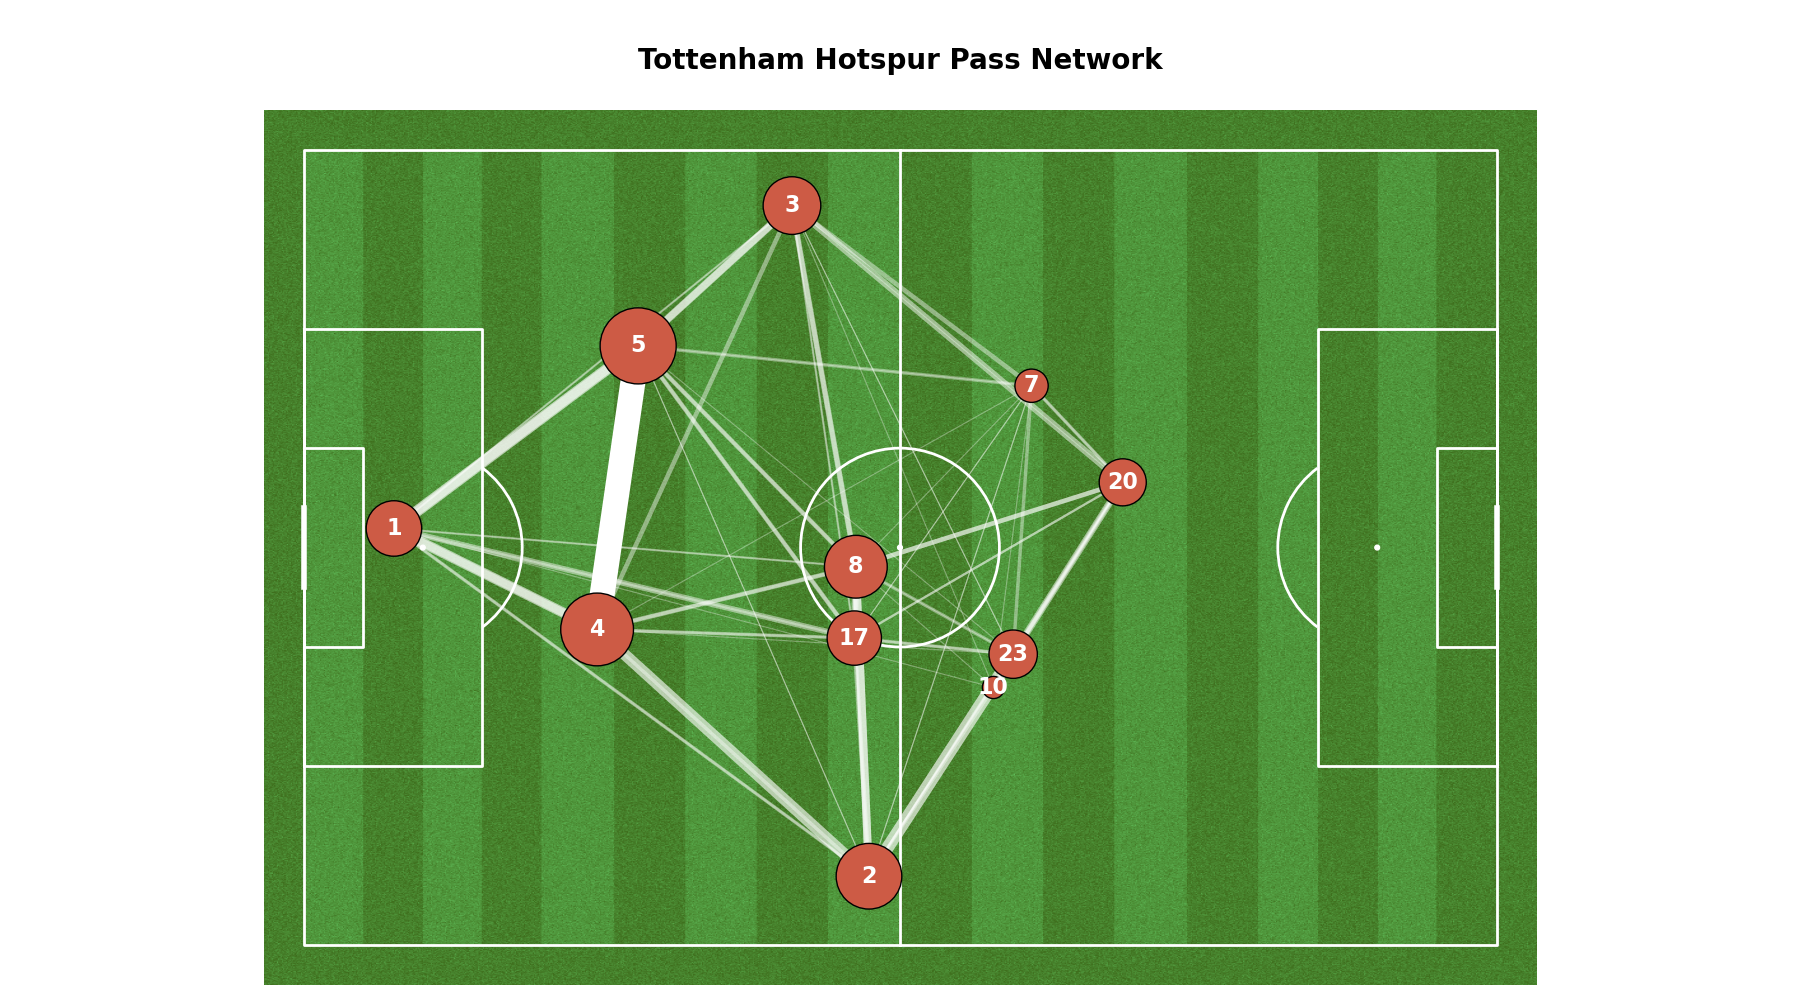

In [11]:
pass_network(team1)

Each players are located at the average x, y location. The lines show "pass" between the players. The number in the circle is a jersey number of each palyer. The number of interactions between the players are encoded with line width, and the number of interactions for each player is encoded with size of the circle.  

## 4. Add interaction

In [23]:
def pass_network(team):
    # Get pass dataframe for the team
    pass_df = get_pass_df(team) 
    
    # boolean mask if the pass is completed
    complete_pass_mask = pass_df.outcome_name.isnull()
    completed_pass = pass_df[complete_pass_mask]
    
    # get first substitution minute
    subs = event_df[event_df.type_name == 'Substitution']
    first_sub_minute = subs['minute'].min()
    #print(first_sub_minute)
    
    # passes before first sub
    completed_pass = completed_pass[completed_pass['minute'] < first_sub_minute]
    # players average passes location x, y and count , player_id => index
    avg_loc_and_count = completed_pass.groupby('player_id').agg({'x': ['mean'], 'y': ['mean', 'count']})
    avg_loc_and_count.columns = ['x', 'y', 'count']
    
    # pass between player_id and pass_recipient_id
    pass_between = completed_pass.groupby(['player_id', 'pass_recipient_id'], as_index=False).id.count().reset_index()
    pass_between.drop('index', axis=1, inplace=True)
    pass_between.columns = ['passer', 'recipient', 'pass_count']
    
    # merge avg_loc table with pass_between table throw passer column to get start x, y
    pass_between = pass_between.merge(avg_loc_and_count, left_on='passer', right_index=True)
    
    # merge avg_loc table with pass_between table throw recipient column to get end x, y
    pass_between = pass_between.merge(avg_loc_and_count, left_on='recipient', right_index=True, suffixes=['', '_end'])
    
    # setup the pitch
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white',
              stripe_color='#c2d59d', stripe=True)
    fig, ax = pitch.draw(figsize=(15,8))
    
    # setup lines and nodes
    MAX_LINE_WIDTH = 18
    MAX_MARKER_SIZE = 3000
    pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() *
                           MAX_LINE_WIDTH)
    avg_loc_and_count['marker_size'] = (avg_loc_and_count['count']
                                         / avg_loc_and_count['count'].max() * MAX_MARKER_SIZE)
    
    # merge players_name to avg_loc_and_count df for tooltips
    temp = players_df[['player_id', 'player_name']].set_index('player_id')
    temp = temp.drop_duplicates(subset=['player_name'])
    avg_loc_and_count = avg_loc_and_count.join(temp)
    
    # setup color transparency based on the number of passes made
    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('white'))
    color = np.tile(color, (len(pass_between), 1))
    c_transparency = pass_between.pass_count / pass_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency
    
    # plot passes network
    pass_lines = pitch.lines(pass_between.x, pass_between.y,
                         pass_between.x_end, pass_between.y_end, lw=pass_between.width,
                         color=color, zorder=1, ax=ax)
                     
    sc = pitch.scatter(avg_loc_and_count.x, avg_loc_and_count.y, 
                  s=avg_loc_and_count.marker_size,
                  color='#CD5B45', edgecolors='black', linewidth=1, alpha=1, ax=ax)
  
                      
    # plot players jersey number
    for index, row in avg_loc_and_count.iterrows():
        # index in avg_loc table is the player_id
        player_jersey_number = players_df[players_df.player_id == index].player_jersey_number.values[0]
        pitch.annotate(player_jersey_number, xy=(row.x, row.y), c='white', va='center', ha='center',
                       size=16, weight='bold', ax=ax)
    ax.set_title(f'\n{team} Pass Network\n', fontsize=20, weight='bold')
    
    cursor = mplcursors.cursor(sc, hover=True )
    # by default the annotation displays the xy positions
    # add a function to show player_name instead of xy positions
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.get_bbox_patch().set(fc="white")
        sel.annotation.set(text=avg_loc_and_count['player_name'].values[sel.target.index])

    plt.show()

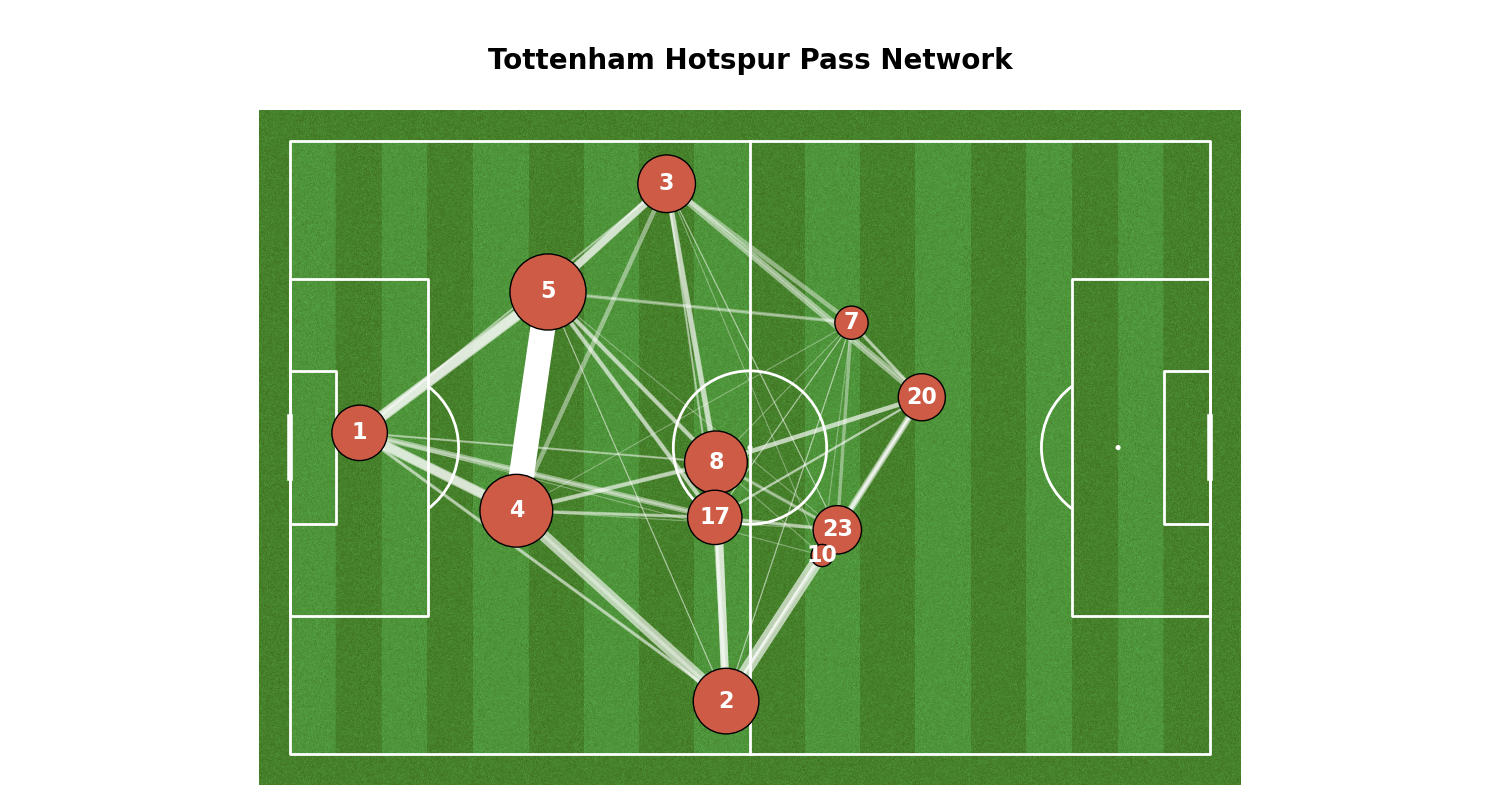

In [24]:
pass_network(team1)